In [23]:
import matplotlib.pyplot as plt
import numpy as np
# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pacoty.mplstyle')
plt.style.use("default")
font = {'size'   : 16}
plt.rc('font', **font)

In [24]:
def parseTiming(fname):
    with open(fname, 'r') as f:
        for line in f:
            if "diverged" in line: raise Exception(f"iterations in file {fname} diverged!")
            if "Braid" in line: continue
            if "wall time" in line: return float(line.split()[-1])

def parseTol(fname, tol):
    with open(fname, 'r') as f:
        for line in f:
            if "diverged" in line: raise Exception(f"iterations in file {fname} diverged!")
            if "Begin" in line: continue
            if "not available" in line: continue
            if "Solver Stats" in line: continue
            if "Braid" in line and "wall time" in line:
                res = float(line.split()[5].split(',')[0])
                if res <= tol:
                    return float(line.split()[-1])

def parseIters(fname):
    with open(fname, 'r') as f:
        for line in f:
            if "max iterations" in line: continue
            if "Max" in line: continue
            if "iterations" in line: return float(line.split()[-1])

In [25]:
ncores = (16, 32, 64, 128, 256, 512, 1024)
mlevels = (4, 4, 4, 4, 4, 4, 4)
thetas = np.zeros(len(ncores))
deltas = np.zeros(len(ncores))
mgrits = np.zeros(len(ncores))
rank = 10
bad_pts = []
tol = 1e-5

serial = parseTiming("ks_ml1")

for i, (nc, ml) in enumerate(zip(ncores, mlevels)):
    thetas[i] = parseTol(f"ks_theta_nc{nc}", tol)
    if np.isnan(thetas[i]):
        thetas[i] = parseTiming(f"ks_theta_nc{nc}")
        bad_pts.append((nc, thetas[i]))

for i, (nc, ml) in enumerate(zip(ncores, mlevels)):
    deltas[i] = parseTol(f"ks_Delta{rank}_nc{nc}", tol)
    if np.isnan(deltas[i]):
        deltas[i] = parseTiming(f"ks_Delta{rank}_nc{nc}")
        bad_pts.append((nc, deltas[i]))

for i, (nc, ml) in enumerate(zip(ncores, mlevels)):
    mgrits[i] = parseTol(f"ks_nc{nc}", tol)
    if np.isnan(mgrits[i]):
        mgrits[i] = parseTiming(f"ks_nc{nc}")
        bad_pts.append((nc, mgrits[i]))

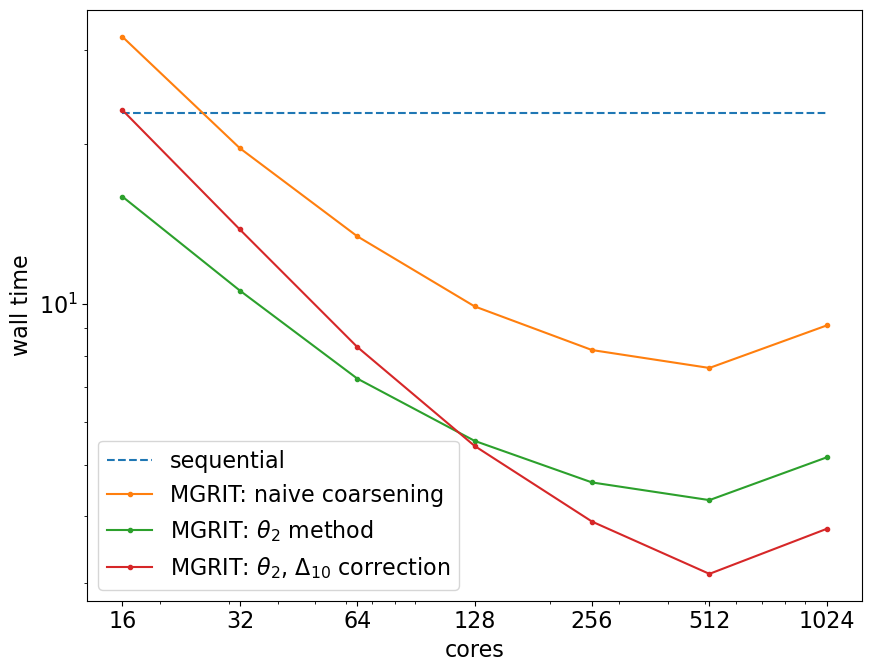

In [26]:
fig, ax = plt.subplots(figsize=(9,7))
ax.loglog(ncores, serial*np.ones(len(ncores)), '--', label="sequential")
ax.loglog(ncores, mgrits, '.-', label="MGRIT: naive coarsening")
ax.loglog(ncores, thetas, '.-', label=r"MGRIT: $\theta_2$ method")
ax.loglog(ncores, deltas, '.-', label=fr"MGRIT: $\theta_2$, $\Delta_{{{rank}}}$ correction")
[ax.plot(*pt, 'rx') for pt in bad_pts]
ax.set_xlabel("cores")
ax.set_ylabel("wall time")
ax.legend()
plt.xticks(ncores, ncores)
# plt.ylim((1e0, 1e2))
plt.tight_layout()
plt.savefig("weak_scaling_KS_128.png", dpi=300)

In [27]:
serial/mgrits

array([0.72 , 1.164, 1.702, 2.304, 2.782, 3.005, 2.501])

In [28]:
serial/thetas

array([1.435, 2.152, 3.146, 4.118, 4.927, 5.317, 4.421])

In [29]:
serial/deltas

array([0.988, 1.653, 2.745, 4.209, 5.834, 7.311, 6.019])